In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.hermite import hermval
from scipy.misc import factorial
%matplotlib inline

/home/raroog/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Reproduction: Shirvany, et. al., "Numerical solution of the nonlinear Schrodinger equation by feedforward neural networks."

The authors propose the solution of a form of a almost-shallow network where we have a single hidden layer with $n_h$ units with sigmoid activation function. Output of the hidden layer is passed to an output layer with $n_o=2$ linear units which in the end are reduced by multipication.

In [2]:
class Solution(tf.keras.models.Model):
  def __init__(self, n_i, n_h, n_o=2, activation='sigmoid'):
    super(Solution, self).__init__()
    
    # Dimension of all the layers
    self.n_i = n_i
    self.n_h = n_h
    self.n_o = n_o
    
    # Shallow network
    # Hidden layer
    self.hidden_layer = tf.keras.layers.Dense(units=n_h, activation=activation,
            kernel_initializer=tf.initializers.GlorotUniform,
            bias_initializer=tf.initializers.GlorotUniform)
    # Output layer
    self.output_layer = tf.keras.layers.Dense(units=n_o, activation='linear', use_bias=False,
            kernel_initializer=tf.initializers.GlorotUniform,
            bias_initializer=tf.initializers.GlorotUniform)
    
  def call(self, X):
    # Conversion to a tensor
    X = tf.convert_to_tensor(X)
    
    # Simple Shallow Network Response
    response = self.hidden_layer(X)
    response = self.output_layer(response)
    
    response = tf.math.reduce_prod(response, axis=1)
    
    return response
  
  def train(self, X, loss_function, epochs, conditions, eigen_value, verbose=True,
            message_frequency=1, learning_rate=0.1, boundary_multiplier=10,
            optimizer_name='Adam'):
    
    # Checking for the right parameters
    if not isinstance(epochs, int) or epochs < 1:
      raise Exception('epochs parameter should be a positive integer.')
    if not isinstance(message_frequency, int) or message_frequency < 1:
      raise Exception(
                'message_frequency parameter should be a positive integer.')
      
    # Choosing the optimizers
    optimizer = None
    if optimizer_name == 'Adam':
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == 'SGD':
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    
    def loss_boundary(network, conditions):
      loss = tf.constant(0., shape=(1,), dtype='float64')
      for condition in conditions:
        X = tf.convert_to_tensor(np.array([condition['value']]).reshape((1,1)))
        boundary_response = tf.reshape(network(X), shape=(-1,))
        boundary_value = condition['function'](X)
        boundary_value = tf.reshape(boundary_value, shape=(-1,))
        loss += (boundary_response - boundary_value) ** 2
      loss = boundary_multiplier*tf.math.reduce_sum(loss)
      return loss

    # Single train step function for the unsupervised equation part
    @tf.function
    def train_step(X, conditions, eigen_value):
      with tf.GradientTape() as tape:
        loss = loss_function(self, X, eigen_value)
      gradients = tape.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      with tf.GradientTape() as tape2:
        loss = loss_boundary(self, conditions)
      gradients = tape2.gradient(loss, self.trainable_variables)
      optimizer.apply_gradients(
                  zip(gradients, self.trainable_variables))
      
    # Training for a given number of epochs
    for epoch in range(epochs):
      train_step(X, conditions, eigen_value)
      equation_loss = loss_function(self, X, eigen_value)
      boundary_loss = loss_boundary(self, conditions)
      if verbose and(epoch+1) % message_frequency == 0:
        print(f'Epoch: {epoch+1} Loss equation: \
              {equation_loss.numpy()} \
              Loss boundary: {boundary_loss.numpy()}')

Accroding to the paper:

>The ANN is trained via the gradient-descent back-propagation method with momentum
term for minimizing the non-negative energy function that is formulated from Schrodinger equation Eq. (6)
and the available boundary conditions.

and

>In the train
state of the network the adjustable parameters of the networks (weights and biases) are tuned by a proper
learning algorithm to minimize the energy function of the network. We train the network via the fast converge
gradient-descend back-propagation method with momentum term [7,23,24] for the non-negative energy func-
tion.

We concluded that it can realised by using the Adam optimizer with online learning.

The loss is defined by sum of unsupervised minimalization of the equation and by supervised optimization for MSE for the boundary conditions:
$$Loss(N)=\sum_i \left(\Delta\Psi(N(x_i))+E\Psi(N(x_i))\right)^2 + \sum_k (\Psi(N(x_k))-C_k)^2$$

## Potential Well

We consider the Shroedinger equation in one dimension:
$$-\frac{d^2}{dx^2}\Psi(x)+V(x)\Psi(x)=E\Psi(x)$$
For the Potential Well problem with
$$V(x)=\begin{cases} 
      0, & x\in[0,L] \\
      \infty, & x\notin(0,L) 
   \end{cases}$$
The equivalent formulation is $V(x)=0$ on the whole domain with the boundary conditions $\Psi(0)=0$ and $\Psi(L)=0$ with the domain of the equation $x\in[0,L]$.


Where we set $\frac{\hbar^2}{2m}=1$.

We set the lenght of the well equal to $4$.

In [3]:
L = 4.

We take 200 equidistant points from the interval $[0, L]$ for the training set and more for the test set.

In [4]:
X_train = np.arange(0, L, L/200) + 1e-8
X_train = X_train.reshape(-1,1)
X_test = np.arange(0, L, 0.001) + 1e-8
X_test = X_test.reshape(-1,1)  

In [5]:
# Defining the boundary conditions
def constant(c):
  def func(X):
    return tf.constant(c, dtype='float64', shape=X.shape)
  return func
bcs = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':constant(0.)},
      {'variable':0, 'value':L, 'type':'dirichlet',
        'function':constant(0.)}]

The term of the loss function representing the equation satisfaction $\sum_i \left(\Delta\Psi(N(x_i))+E\Psi(N(x_i))\right)^2$

In [6]:
def loss_well(network, X, eigen_value):
  X = tf.convert_to_tensor(X)
  # Taking the frist (grads) and the second (laplace) derivatives w. r. t. inputs
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      tape1.watch(X)
      tape2.watch(X)
      response = network(X)
    grads = tape2.gradient(response, X)
  laplace = tape1.gradient(grads, X)
  
  psi = tf.reshape(response, shape=(-1,))  
  nabla = tf.reshape(laplace, shape=(-1,))
  loss = (nabla + eigen_value * psi) ** 2
  
  return tf.math.reduce_mean(loss)      

The authors have found $n_h=105$ to be optimal size of the network.

Let's check if such a solution finds the eigen function corresponidng to the first $5$ eigen_values calculated as $E(n)=\left(\frac{n\pi}{L} \right)^2,\, n=1,2,3,\dots$ .

In [7]:
def eigen_value_well(n):
  return (n * np.pi / L)**2

Defining the function finding the solution and plotting.

In [8]:
def potential_well_solve_plot(n):
  sol = Solution(n_i=1, n_h=40, n_o=2)
  sol.train(X=X_train, conditions=bcs, eigen_value=eigen_value_well(n), loss_function=loss_well,
            epochs=10000, verbose=False, message_frequency=100, boundary_multiplier=0.1,
            learning_rate=0.01, optimizer_name='Adam')
  
  pred_train = sol(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
  train_normalization = (pred_train**2).sum()*L/pred_train.shape[0]
  print(train_normalization)
  pred_train /= train_normalization
  pred_test = sol(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
  test_normalization = (pred_test**2).sum()*L/pred_test.shape[0]
  print(test_normalization)
  pred_test /= test_normalization
  plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
  plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
  plt.plot(X_test, np.sin(n*np.pi/L*X_test)/np.sqrt(2), c='b', label='Analytic')
  plt.legend()
  plt.title(f'Solution for n={n}')
  plt.show()
  return sol

For $n=1$.

W0520 20:44:12.741052 139993760626432 deprecation.py:323] From /home/raroog/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:167: setdiff1d (from tensorflow.python.ops.array_ops) is deprecated and will be removed after 2018-11-30.
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


8.463934475011464e-10
8.463938254279896e-10


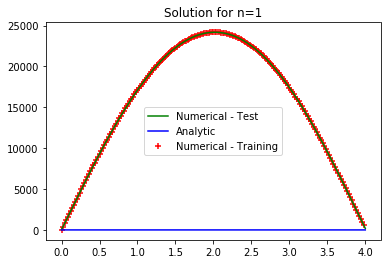

In [9]:
pw_n1 = potential_well_solve_plot(1)

For $n=2$.

9.877362770538815e-06
9.899786347930111e-06


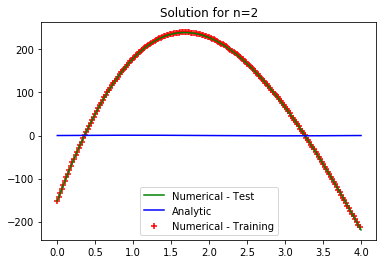

In [10]:
pw_n2 = potential_well_solve_plot(2)

For $n=3$.

1.1986252582618012e-11
1.188150981205847e-11


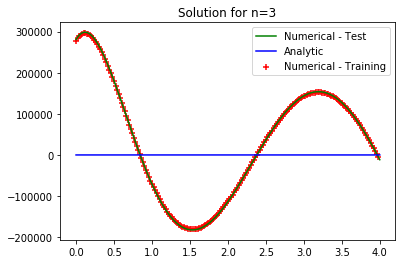

In [11]:
pw_n3 = potential_well_solve_plot(3)

For $n=4$.

3.802559499485874e-12
3.79660737265792e-12


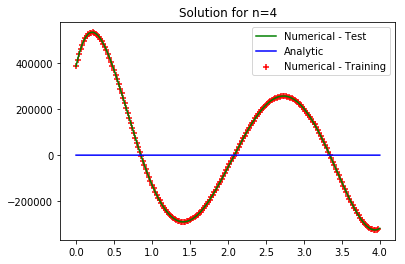

In [12]:
pw_n4 = potential_well_solve_plot(4)

For $n=5$.

5.096985475295455e-12
5.089131097262867e-12


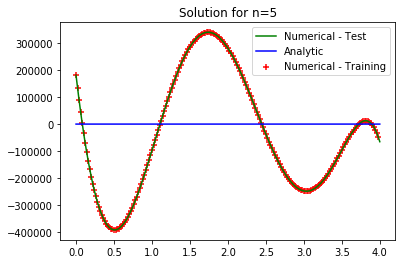

In [13]:
pw_n5 = potential_well_solve_plot(5)

For $n=6$.

2.219593480460255e-14
2.2193118613327485e-14


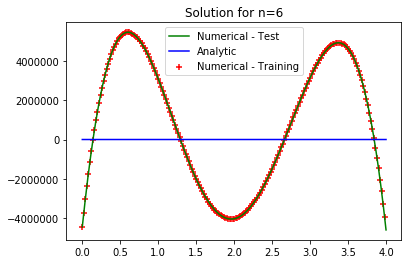

In [14]:
pw_n6 = potential_well_solve_plot(6)

The network converges to an almost trivial vanishing solution of the equation, so while plotting, we normalize the solution by the maximum of the numerical solution.

### Let's try to fix it by adding an additional point

By analytic considerations, we know that for $n=1$ the maximum of the eigenfunction is for $x=L/2$ and is equal to $\Psi(L/2)=2^{-0.5}$, so let's add it as an additional initial condition.

In [15]:
bcs2 = [{'variable':0, 'value':0, 'type':'dirichlet',
        'function':constant(0.)},
      {'variable':0, 'value':L, 'type':'dirichlet',
        'function':constant(0.)},
      {'variable':0, 'value':L*0.5, 'type':'dirichlet',
        'function':constant(np.power(2,-0.5))}]

In [16]:
sol2 = Solution(n_i=1, n_h=105, n_o=2)

For $n=1$.

In [17]:
sol2.train(X=X_train, conditions=bcs2, eigen_value=eigen_value_well(1), loss_function=loss_well,
           epochs=10000, message_frequency=1000,learning_rate=0.01, optimizer_name='Adam', verbose=True)

Epoch: 1000 Loss equation:               0.01858659773600406               Loss boundary: 0.00042094610512469004
Epoch: 2000 Loss equation:               0.007707294677916479               Loss boundary: 0.0005842260175824455
Epoch: 3000 Loss equation:               0.0013011671132108016               Loss boundary: 0.000166559177134537
Epoch: 4000 Loss equation:               0.00124248460595732               Loss boundary: 0.00040812291877174057
Epoch: 5000 Loss equation:               0.0008400297834824731               Loss boundary: 1.2478511261599134e-05
Epoch: 6000 Loss equation:               0.0007132044859840314               Loss boundary: 1.1749216677637201e-05
Epoch: 7000 Loss equation:               0.0006310845927020059               Loss boundary: 2.98039579799173e-06
Epoch: 8000 Loss equation:               0.00044789428081050094               Loss boundary: 4.333556292797359e-06
Epoch: 9000 Loss equation:               0.00031222602761647066               Loss boundar

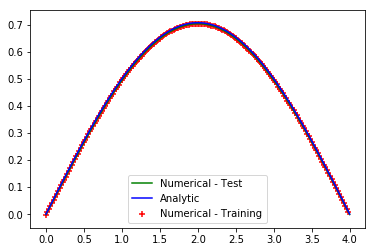

In [18]:
pred_train2 = sol2(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
# pred_train2 /= pred_train2.max()
pred_test2 = sol2(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
# pred_test2 /= pred_test2.max()
plt.scatter(X_train, pred_train2, c='r', label='Numerical - Training', marker='+', s=30)
plt.plot(X_test, pred_test2, c='g', label='Numerical - Test')
plt.plot(X_test, np.sin(np.pi/L*X_test)/np.sqrt(2), c='b', label='Analytic')
plt.legend()
plt.show()

This is a convincing sanity check that the network works, but requires additional condition, so the solution does not vanish.

## Forcing summation to **1** - probabilistic interpretation

In [19]:
def loss_well_unity(network, X, eigen_value):
  X = tf.convert_to_tensor(X)
  # Taking the frist (grads) and the second (laplace) derivatives w. r. t. inputs
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      tape1.watch(X)
      tape2.watch(X)
      response = network(X)
    grads = tape2.gradient(response, X)
  laplace = tape1.gradient(grads, X)
  
  psi = tf.reshape(response, shape=(-1,))  
  nabla = tf.reshape(laplace, shape=(-1,))
  loss = (nabla + eigen_value * psi) ** 2
  
  interval = X[1]
  probability_unity = tf.math.reduce_sum(response**2) * interval 
  probability_unity = (probability_unity - 1) **2
  loss = tf.math.reduce_mean(loss) + probability_unity
  return loss

In [20]:
def potential_well_unity_solve_plot(n):
  sol = Solution(n_i=1, n_h=40, n_o=2)
  sol.train(X=X_train, conditions=bcs, eigen_value=eigen_value_well(n), loss_function=loss_well_unity,
            epochs=50000, verbose=True, message_frequency=1000, boundary_multiplier=0.1,
            learning_rate=0.01, optimizer_name='Adam')
  
  pred_train = sol(tf.convert_to_tensor(X_train, dtype='float64')).numpy()
  train_normalization = (pred_train**2).sum()*L/pred_train.shape[0]
  print(train_normalization)
  pred_train /= np.sign(pred_train.sum())
  pred_test = sol(tf.convert_to_tensor(X_test, dtype='float64')).numpy()
  test_normalization = (pred_test**2).sum()*L/pred_test.shape[0]
  print(test_normalization)
  pred_test /= np.sign(pred_test.sum())
  plt.scatter(X_train, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
  plt.plot(X_test, pred_test, c='g', label='Numerical - Test')
  plt.plot(X_test, np.sin(n*np.pi/L*X_test)/np.sqrt(2), c='b', label='Analytic')
  plt.legend()
  plt.title(f'Solution for n={n}')
  plt.show()
  return sol

For $n=1$.

Epoch: 1000 Loss equation:               [0.06481134]               Loss boundary: 0.059355828448572484
Epoch: 2000 Loss equation:               [0.03030907]               Loss boundary: 0.011156776211991386
Epoch: 3000 Loss equation:               [0.00111452]               Loss boundary: 0.0001273062760669938
Epoch: 4000 Loss equation:               [0.00081601]               Loss boundary: 1.665616516677833e-05
Epoch: 5000 Loss equation:               [0.00292314]               Loss boundary: 5.2308431569344106e-05
Epoch: 6000 Loss equation:               [0.00264112]               Loss boundary: 4.7957766541240335e-05
Epoch: 7000 Loss equation:               [0.00218817]               Loss boundary: 4.152734518132739e-05
Epoch: 8000 Loss equation:               [0.00180691]               Loss boundary: 3.440789482194688e-05
Epoch: 9000 Loss equation:               [0.00148447]               Loss boundary: 2.819078125114264e-05
Epoch: 10000 Loss equation:               [5.09032051e-

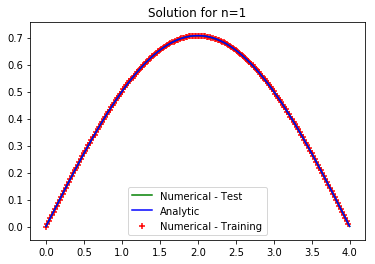

In [21]:
pwu_n1 = potential_well_unity_solve_plot(1)

For $n=2$.

Epoch: 1000 Loss equation:               [0.4205725]               Loss boundary: 0.019745113370773434
Epoch: 2000 Loss equation:               [0.3257818]               Loss boundary: 0.022153833097892317
Epoch: 3000 Loss equation:               [0.00680572]               Loss boundary: 0.004586101533349817
Epoch: 4000 Loss equation:               [0.00181021]               Loss boundary: 1.7068404543687537e-05
Epoch: 5000 Loss equation:               [0.00113221]               Loss boundary: 3.8515011148382e-05
Epoch: 6000 Loss equation:               [0.00087421]               Loss boundary: 2.065502449963205e-05
Epoch: 7000 Loss equation:               [0.00183914]               Loss boundary: 7.526257154920088e-05
Epoch: 8000 Loss equation:               [0.00228305]               Loss boundary: 7.479048657659573e-05
Epoch: 9000 Loss equation:               [0.00191742]               Loss boundary: 5.636479464802373e-05
Epoch: 10000 Loss equation:               [0.00244137]       

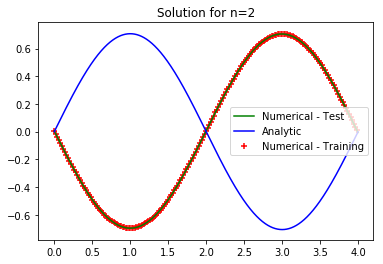

In [22]:
pwu_n2 = potential_well_unity_solve_plot(2)

For $n=3$.

In [23]:
pwu_n3 = potential_well_unity_solve_plot(3)

Epoch: 1000 Loss equation:               [1.00000006]               Loss boundary: 2.1097414465268996e-09
Epoch: 2000 Loss equation:               [1.00000001]               Loss boundary: 4.6919548832226e-10
Epoch: 3000 Loss equation:               [1.]               Loss boundary: 4.444609246315984e-12
Epoch: 4000 Loss equation:               [1.]               Loss boundary: 3.818958348172703e-12
Epoch: 5000 Loss equation:               [1.]               Loss boundary: 3.700503750350523e-12


KeyboardInterrupt: 

For $n=4$.

In [ ]:
pwu_n4 = potential_well_unity_solve_plot(4)

For $n=5$.

In [ ]:
pwu_n5 = potential_well_unity_solve_plot(5)

For $n=6$.

In [ ]:
pwu_n6 = potential_well_unity_solve_plot(6)

## Harmonic oscillator

Now, let's try to reproduce the solutions for the harmonic oscillator
$$-\frac{1}{2}\frac{d^2}{dx^2}\Psi(x)+\frac{1}{2}x^2\Psi(x)=E\Psi(x)$$
 with the domain $x\in[-L,L]$.

In [24]:
X_train_ho = np.arange(-L, L, 2*L/200) + 1e-8
X_train_ho = X_train_ho.reshape(-1,1)

With boundary conditions $\Psi(-L)=0$ and $\Psi(L)=0$.

In [25]:
bcs3 = [{'variable':0, 'value':-L, 'type':'dirichlet',
        'function':constant(0.)},
      {'variable':0, 'value':L, 'type':'dirichlet',
        'function':constant(0.)}]

The term of the loss function representing the boundary conditions $\sum_k (\Psi(N(x_k))-C_k)^2$

In [26]:
def loss_harmonic(network, X, eigen_value):
  X = tf.convert_to_tensor(X)
  
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      tape1.watch(X)
      tape2.watch(X)
      response = network(X)
    grads = tape2.gradient(response, X)
  laplace = tape1.gradient(grads, X)
  
  nabla = tf.reshape(laplace, shape=(-1,))
  psi = tf.reshape(response, shape=(-1,))
  x = tf.reshape(X, shape=(-1,))
  
  eigen_value_tensor = tf.constant(eigen_value, shape=(X.shape[0], ), dtype='float64')
  
  loss = tf.square(0.5*nabla + (eigen_value_tensor - 0.5*x** 2) * psi)
  
  return tf.math.reduce_mean(loss)

The analytic solution in terms of the Hermit polynomials.

In [27]:
def harmonic_analytic(X, n):
  # degree parameter of the polynomial
  c = np.zeros((n+1))
  c[n] = 1
  value = hermval(X, c)
  value *= np.power(np.pi, -0.25)
  value /= np.sqrt(2 ** n * factorial(n))
  value *= np.exp(-0.5*X**2)
  return value

The authors have found $n_h=40$ to be optimal size of the network for the problem.

Let's check if such a solution finds the eigen function corresponidng to the first $5$ eigen_values calculated as $E(n)=n+0.5,\, n=0,1,2,3,\dots$ .

In [28]:
def eigen_value_harmonic(n):
  return n + 0.5

In [31]:
def harmonic_solve_plot(n):
  sol = Solution(n_i=1, n_h=40, n_o=2)
  sol.train(X=X_train_ho, conditions=bcs3, eigen_value=eigen_value_well(n), loss_function=loss_harmonic,
            epochs=10000, verbose=True, message_frequency=1000, boundary_multiplier=0.1,
            learning_rate=0.1, optimizer_name='Adam')
  
  pred_train = sol(tf.convert_to_tensor(X_train_ho, dtype='float64')).numpy()
  train_normalization = (pred_train**2).sum()*L/pred_train.shape[0]
  print(train_normalization)
  pred_train /= np.sign(pred_train.sum())
  pred_test = sol(tf.convert_to_tensor(X_train_ho, dtype='float64')).numpy()
  test_normalization = (pred_test**2).sum()*L/pred_test.shape[0]
  print(test_normalization)
  pred_test /= np.sign(pred_test.sum())
  plt.scatter(X_train_ho, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
  plt.plot(X_train_ho, pred_test, c='g', label='Numerical - Test')
  plt.plot(X_train_ho, harmonic_analytic(X_train_ho, n), c='b', label='Analytic')
  plt.legend()
  plt.title(f'Solution for n={n}')
  plt.show()
  return sol

For $n=0$.

Epoch: 1000 Loss equation:               4.917641844235414e-06               Loss boundary: 5.780027143829956e-08
Epoch: 2000 Loss equation:               4.5339479969565143e-07               Loss boundary: 2.747821649894518e-08
Epoch: 3000 Loss equation:               2.2101784077326107e-07               Loss boundary: 6.79457157756589e-09
Epoch: 4000 Loss equation:               7.627556119696061e-08               Loss boundary: 2.6309751383399757e-09
Epoch: 5000 Loss equation:               0.002097281147155631               Loss boundary: 0.0013458370219521195
Epoch: 6000 Loss equation:               0.0012991324893858085               Loss boundary: 0.0013586949010690557
Epoch: 7000 Loss equation:               0.0010695727009485546               Loss boundary: 0.0009642282005486946
Epoch: 8000 Loss equation:               0.0006675177714557235               Loss boundary: 0.0005083275891350817
Epoch: 9000 Loss equation:               0.00023818642206701533               Loss boun

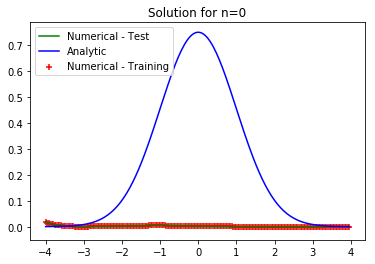

In [32]:
ho_n0 = harmonic_solve_plot(0)

For $n=1$.

In [ ]:
ho_n1 = harmonic_solve_plot(1)

For $n=2$.

In [ ]:
ho_n2 = harmonic_solve_plot(2)

For $n=3$.

In [ ]:
ho_n3 = harmonic_solve_plot(3)

For $n=4$.

In [ ]:
ho_n4 = harmonic_solve_plot(4)

For $n=5$.

In [ ]:
ho_n5 = harmonic_solve_plot(5)

What is interesting is that it is not even matter of normalization what could be a case, but the solution simply vanishes.

## Forcing summation to **1** - probabilistic interpretation

In [62]:
def loss_harmonic_unity(network, X, eigen_value):
  X = tf.convert_to_tensor(X)
  
  with tf.GradientTape() as tape1:
    with tf.GradientTape() as tape2:
      tape1.watch(X)
      tape2.watch(X)
      response = network(X)
    grads = tape2.gradient(response, X)
  laplace = tape1.gradient(grads, X)
  
  nabla = tf.reshape(laplace, shape=(-1,))
  psi = tf.reshape(response, shape=(-1,))
  x = tf.reshape(X, shape=(-1,))
  
  eigen_value_tensor = tf.constant(eigen_value, shape=(X.shape[0], ), dtype='float64')
  
  loss = tf.square(0.5*nabla + (eigen_value_tensor - 0.5*x** 2) * psi)
  
  interval = X[1]-X[0]
  probability_unity = tf.math.reduce_sum(response**2) * interval 
  probability_unity = (probability_unity - 1) **2
  loss = tf.math.reduce_mean(loss) + probability_unity
  return loss

In [70]:
def harmonic_solve_plot_unity(n):
  sol = Solution(n_i=1, n_h=105, n_o=2)
  sol.train(X=X_train_ho, conditions=bcs3, eigen_value=eigen_value_well(n), loss_function=loss_harmonic_unity,
            epochs=10090, verbose=True, message_frequency=1000, boundary_multiplier=0.1,
            learning_rate=0.01, optimizer_name='Adam')
  
  pred_train = sol(tf.convert_to_tensor(X_train_ho, dtype='float64')).numpy()
  train_normalization = (pred_train**2).sum()*L/pred_train.shape[0]
  print(train_normalization)
  pred_train /= np.sign(pred_train.sum())
  pred_test = sol(tf.convert_to_tensor(X_train_ho, dtype='float64')).numpy()
  test_normalization = (pred_test**2).sum()*L/pred_test.shape[0]
  print(test_normalization)
  pred_test /= np.sign(pred_test.sum())
  plt.scatter(X_train_ho, pred_train, c='r', label='Numerical - Training', marker='+', s=30)
  plt.plot(X_train_ho, pred_test, c='g', label='Numerical - Test')
  plt.plot(X_train_ho, harmonic_analytic(X_train_ho, n), c='b', label='Analytic')
  plt.legend()
  plt.title(f'Solution for n={n}')
  plt.show()
  return sol

For $n=0$.

Epoch: 1000 Loss equation:               [0.99989717]               Loss boundary: 8.332576768287872e-08
Epoch: 2000 Loss equation:               [5.35884207]               Loss boundary: 0.14152641535337704
Epoch: 3000 Loss equation:               [1.49353143]               Loss boundary: 0.03006998076499577
Epoch: 4000 Loss equation:               [1.10677994]               Loss boundary: 0.0065285470579707645
Epoch: 5000 Loss equation:               [0.74724255]               Loss boundary: 0.003934346313405084
Epoch: 6000 Loss equation:               [0.31229275]               Loss boundary: 0.003994790212278925
Epoch: 7000 Loss equation:               [0.13663117]               Loss boundary: 0.0007211095946208289
Epoch: 8000 Loss equation:               [0.09758791]               Loss boundary: 0.00036215984677949404
Epoch: 9000 Loss equation:               [0.06723587]               Loss boundary: 0.0002920968048078725
Epoch: 10000 Loss equation:               [0.25185629]      

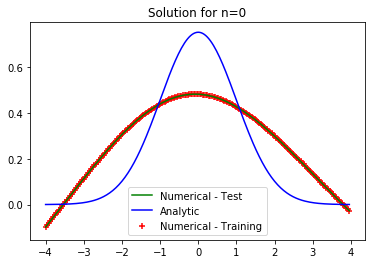

In [73]:
hou_n0 = harmonic_solve_plot_unity(0)

## Automatic eigenvalue search

Now, we implement the automatic eigenvalue search proposed by the authors.

In [ ]:
class Solver:
  def __init__(self, n_i=1, n_h=1, tolerance=1e-8, max_iter=10000,
               max_eigen_counter=1e4, delta_E = 1e-4):
    self.n_i = n_i
    self.n_h = n_h
    self.tolerance = tolerance
    self.max_iter = max_iter
    self.max_eig_counter = max_eigen_counter
    self.sol = Solution(n_i, n_h=1)
    self.eigen_value = 0
    self.delta_E = delta_E
    
  def solve(self, X, conditions, loss_function, epochs=1,
            message_frequency=1, learning_rate=0.1, optimizer='Adam', verbose=False):
    eigenvalue_counter = 0
    iteration_number = 0
    loss = (loss_function(self.sol, X, self.eigen_value) + loss_boundary(self.sol, conditions)).numpy().mean()
    while loss > self.tolerance:
      self.sol.train(X=X, conditions=conditions, eigen_value=self.eigen_value,
                       loss_function=loss_function,
                       epochs=self.max_iter, message_frequency=message_frequency, learning_rate=0.01,
                       optimizer_name=optimizer, verbose=verbose)
      loss = (loss_function(self.sol, X, self.eigen_value) + loss_boundary(self.sol, conditions)).numpy().mean()
      if loss < self.tolerance:
        break
      else:
        self.eigen_value += self.delta_E
        iteration_number = 0
        if eigenvalue_counter < self.max_eig_counter:
          eigenvalue_counter += 1
          print(f'Rising the eigen value number {eigenvalue_counter}')
        else:
          print('Need more power!')
          self.n_h += 1
          self.sol = Solution(n_i=self.n_i, n_h=self.n_h)
          eigenvalue_counter = 0
      loss = (loss_function(self.sol, X, self.eigen_value) + loss_boundary(self.sol, conditions)).numpy().mean()
    return self.eigen_value, self.sol

In [ ]:
# solver = Solver(tolerance=1e-12, max_iter=100, delta_E=1e-2, max_eigen_counter=1e2, n_h=10)

In [ ]:
# solver.solve(X=X_train_ho, conditions=bcs3, loss_function=loss_harmonic, boundary_loss=loss_boundary)